 #                                         Speech-To-Text

In [111]:
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imutils import paths
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

%matplotlib inline

In [112]:
# Spectrogram Libraries
from scipy.io.wavfile import read
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Audio 
import matplotlib.patches as patches

In [113]:
#Spectrogram Functions
def apply_hamming_window(signal):
    # Aplica la ventana de Hamming a la señal
    window = np.hamming(len(signal))
    windowed_signal = signal * window
    return windowed_signal

def extraer_ventanas(signal, size, fs):
    #Tamano de paso
    step=int(0.010*fs)
    n_seg = int((len(signal) - size) / step)
    # extraer segmentos
    windows = [signal[i * step : i * step + size]
        for i in range(n_seg)]
    # stack (cada fila es una ventana)
    return np.vstack(windows)

def potspec(X, size, n_padded_min=0):
    # Zero padding
    if (n_padded_min == 0):
        n_padded = max(n_padded_min, int(2 ** np.ceil(np.log(size) / np.log(2))))
    else:
        n_padded = n_padded_min

    # Transformada de Fourier
    Y = np.fft.fft(X, n = n_padded)
    Y = np.absolute(Y)

    # non-redundant part
    m = int(n_padded / 2) + 1
    Y = Y[:, :m]
    Img = Y.imag
    Real = Y.real
    spec = np.sqrt(Real**2+ Img**2)

    return spec, n_padded

### Spectrogram

In [159]:
audios_dir = r'C:\Base User Documents\UdeA\Electrónica\Semestre 2\PDS\PDS-Training Data\train\audio'

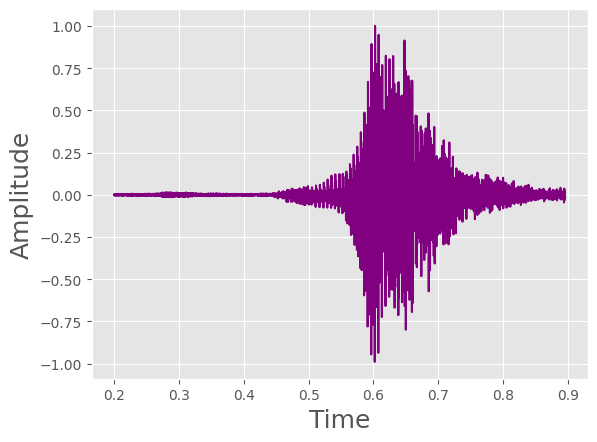

In [160]:
aud_dir = r'C:\Base User Documents\UdeA\Electrónica\Semestre 2\PDS\PDS-Short Training\train\audio\right\00b01445_nohash_0.wav'
file_audio = (aud_dir) # Ruta del archivo con la senal
fs, x = read(file_audio) # Cargar el archivo
x = x/float(max(abs(x))) # escala la amplitud de la senal

ns_cut = 0.2 # tiempo de corte de la senal en segundos
xs = x[int(ns_cut*fs)::]

# Graficar la senal de audio
t1 = np.arange(0.2, float(len(x))/fs, 1.0/fs) # Vector de tiempo
plt.plot(t1, xs, color='purple') # Dibujar la grafica
# Los siguientes dos comandos dibujan las etiquetas de los ejes
plt.xlabel('Time',fontsize=18) # Etiqueta eje X
plt.ylabel('Amplitude',fontsize=18) # Etiqueta eje Y

plt.show() # Mostrar la grafica
Audio(xs, rate=fs) # para escuchar la senal, si se desea

In [161]:
# Signal Spectrogram
s1 = int(25/1000 * fs)
wind1 = extraer_ventanas(xs, s1 , fs)

W_ham1 =[]
for i in wind1:
    W_ham1.append(apply_hamming_window(i))

In [162]:
espectro, nfft = potspec(W_ham1,s1, 4096)
espectro += np.finfo(float).eps
espectrolog = np.flipud(10*np.log10(espectro).T) 


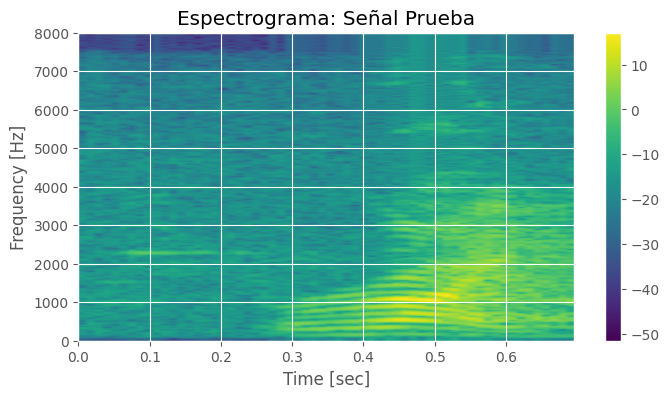

In [163]:
plt.figure(figsize=(8,4))
plt.title('Espectrograma: Señal Prueba')
plt.imshow(espectrolog[:2048,:60],aspect='auto', extent = [0, len(xs)/fs, 0, fs//2])

plt.ylabel('Frequency [Hz]', fontsize = 12)
plt.xlabel('Time [sec]', fontsize = 12)
plt.colorbar()
plt.show()

In [120]:
words = ["left", "right","up","down"]

### Load Audio Data

In [164]:
data = []
labels = []
dirs = os.listdir(audios_dir)
for d in dirs:
    if d in words:
        print(d)
        files = os.listdir(os.path.join(audios_dir,d))
        audios = [f for f in files if f.endswith('.wav')]
        for file in range(1000):
            # load the image, swap color channels, and resize it to be a fixed
            # 224x224 pixels while ignoring aspect ratio
            #file = audios[i]
            file_audio = (os.path.join(audios_dir,d,audios[file]))
            fs, x = read(file_audio)
            x = x/float(max(abs(x)))
            xs = x[int(ns_cut*fs)::]
            # Signal Spectrogram
            s1 = int(25/1000 * fs)
            wind1 = extraer_ventanas(xs, s1 , fs)

            W_ham1 =[]
            for i in wind1:
                W_ham1.append(apply_hamming_window(i))

            spectrogram, nfft = potspec(W_ham1,s1, 4096) 
            spectrogram += np.finfo(float).eps
            spectrogram = np.flipud(np.log(spectrogram).T)

            # convert the image data to NumPy arrays while scaling the pixel
            # intensities to the range [0, 255]
            #image = np.array(image)/255.0
            
            # update the data and labels lists, respectively
            if spectrogram.shape[0] >= 2048 and spectrogram.shape[1] >=60:
                data.append(spectrogram[:2048,:60])
                labels.append(d)
            #else:
             #   print(spectrogram.shape)


down
left
right
up


In [166]:
data = np.array(data)

### Class distribution

In [167]:
values,count = np.unique(labels,return_counts=True)

In [168]:
print(values)

['down' 'left' 'right' 'up']


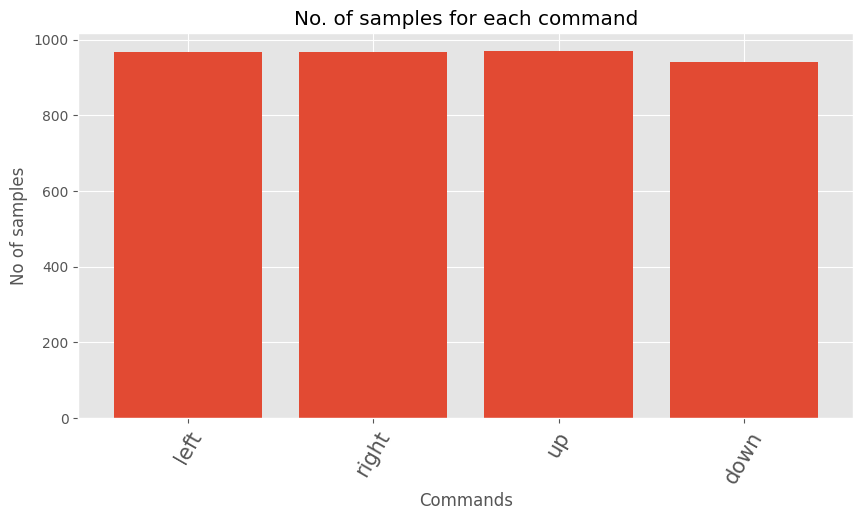

In [169]:
import matplotlib.pyplot as plt
#plot
plt.figure(figsize=(10,5))
index = np.arange(len(words))
plt.bar(index, count)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of samples', fontsize=12)
plt.xticks(index, words, fontsize=15, rotation=60)
plt.title('No. of samples for each command')
plt.show()

In [170]:
labels_backup = labels

In [171]:
# convert the labels to NumPy arrays while scaling the pixel
labels = np.array(labels)

In [172]:
# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ls = le.fit_transform(labels)

In [173]:
labels_categoricals = to_categorical(ls)

### Data splitting - Train,CV and Test 

In [174]:
# partition the data into training,cross-validation and testing splits using 60%,20% and 20% of data
(trainX, testX, trainY, testY) = train_test_split(data, labels_categoricals,test_size=0.20, stratify=labels_categoricals, random_state=42)
(trainX, cvX, trainY, cvY) = train_test_split(trainX, trainY,test_size=0.25, stratify=trainY, random_state=42)

In [175]:
print("Train data size : ",trainX.shape)
print("Cross-Validation data size : ",cvX.shape)
print("Test data size : ",testX.shape)

Train data size :  (2307, 2048, 60)
Cross-Validation data size :  (769, 2048, 60)
Test data size :  (769, 2048, 60)


In [176]:
del data
del labels_categoricals

In [177]:
from keras import backend as K

# input image dimensions
img_rows, img_cols = 2048, 60

if K.image_data_format() == 'channels_first':
    trainX = trainX.reshape(trainX.shape[0], 1, img_rows, img_cols)
    testX = testX.reshape(testX.shape[0], 1, img_rows, img_cols)
    cvX = cvX.reshape(cvX.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    trainX = trainX.reshape(trainX.shape[0],img_rows, img_cols,1)
    testX = testX.reshape(testX.shape[0],img_rows, img_cols,1)
    cvX = cvX.reshape(cvX.shape[0],img_rows, img_cols,1)
    input_shape = (img_rows, img_cols,1)

In [178]:
print("Number of training examples :", trainX.shape[0], "and each image is of shape :",trainX.shape)
print("Number of cross validation examples :", cvX.shape[0], "and each image is of shape :",cvX.shape)
print("Number of testing examples :", testX.shape[0], "and each image is of shape :",testX.shape)

Number of training examples : 2307 and each image is of shape : (2307, 2048, 60, 1)
Number of cross validation examples : 769 and each image is of shape : (769, 2048, 60, 1)
Number of testing examples : 769 and each image is of shape : (769, 2048, 60, 1)


### VGG16 Model

In [179]:
#initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-2
EPOCHS = 10
batch_size = 64
num_class = len(words)
#input_shape = (224,224,3) #(513, 800, 3)

In [180]:
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.layers import Dropout,Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix

In [181]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(2, 2),padding='same',activation='relu',input_shape=input_shape))
model.add(Conv2D(16, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=(2, 2),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 2048, 60, 8)       40        
                                                                 
 conv2d_13 (Conv2D)          (None, 2048, 60, 16)      528       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 1024, 30, 16)      0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 1024, 30, 16)      64        
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 1024, 30, 16)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 1024, 30, 32)     

In [182]:
#from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=INIT_LR)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [183]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [184]:
history = model.fit(trainX, trainY, batch_size=batch_size, epochs=EPOCHS, verbose=1, callbacks=[es,mc],validation_data=(cvX, cvY))

Epoch 1/10
37/37 [==============================] - 278s 7s/step - loss: 17.3197 - accuracy: 0.3403 - val_loss: 22.6802 - val_accuracy: 0.2510
Epoch 2/10
37/37 [==============================] - 276s 7s/step - loss: 1.3113 - accuracy: 0.3879 - val_loss: 15.2956 - val_accuracy: 0.2510
Epoch 3/10
37/37 [==============================] - 755s 21s/step - loss: 1.1763 - accuracy: 0.4408 - val_loss: 9.3272 - val_accuracy: 0.2510
Epoch 4/10
37/37 [==============================] - 269s 7s/step - loss: 1.1116 - accuracy: 0.4655 - val_loss: 5.1688 - val_accuracy: 0.2549
Epoch 5/10
37/37 [==============================] - 269s 7s/step - loss: 1.0874 - accuracy: 0.5020 - val_loss: 4.0459 - val_accuracy: 0.2536
Epoch 6/10
37/37 [==============================] - 267s 7s/step - loss: 1.0779 - accuracy: 0.5223 - val_loss: 6.3909 - val_accuracy: 0.2510
Epoch 7/10
37/37 [==============================] - 266s 7s/step - loss: 0.9874 - accuracy: 0.5540 - val_loss: 3.0340 - val_accuracy: 0.2744
Epoch 8/1

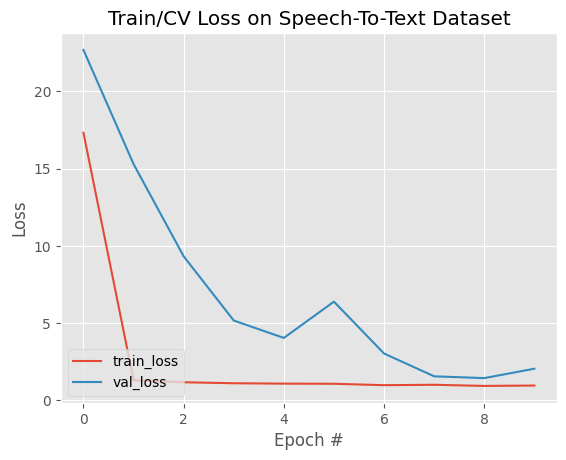

In [185]:
# plot the training loss
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Train/CV Loss on Speech-To-Text Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

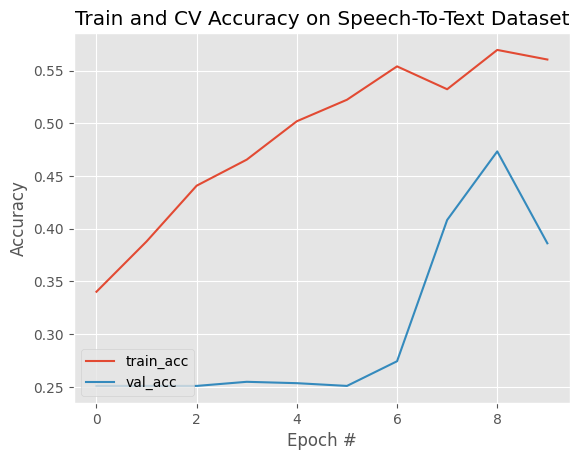

In [186]:
# plot the training accuracy
N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Train and CV Accuracy on Speech-To-Text Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [193]:
best_acc = max(history.history["accuracy"])*100
best_val_acc = max(history.history["val_accuracy"])*100

In [187]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=batch_size)

13/13 [==============================] - 14s 1s/step


In [188]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [205]:
def plot_Confusion_Matrix(actual_labels,predict_labels,title):
    """This function plot the confusion matrix"""
    # Reference : https://seaborn.pydata.org/generated/seaborn.heatmap.html
    cm = confusion_matrix(actual_labels, predict_labels)
    classNames = words
    cm_data = pd.DataFrame(cm,index = classNames,
                  columns = classNames)
    plt.figure(figsize = (8,8))
    sns.heatmap(cm_data, annot=True,fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    return cm


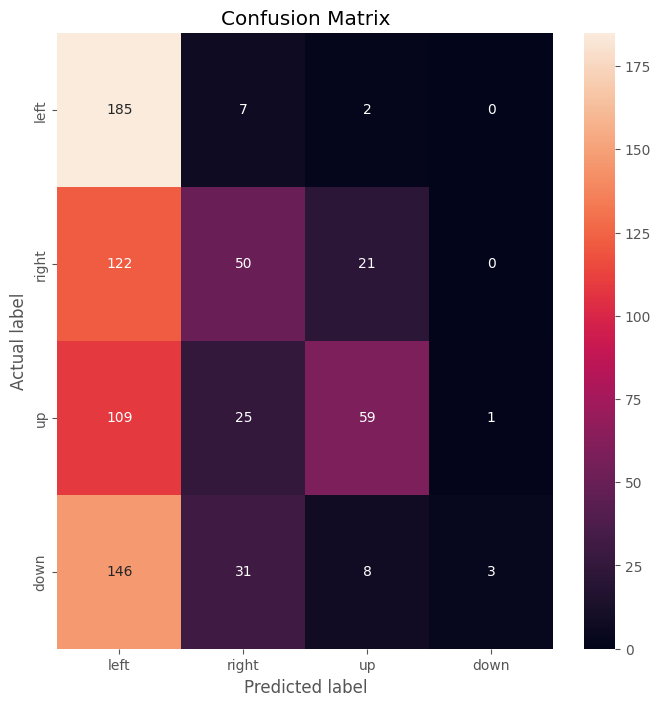

In [206]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = plot_Confusion_Matrix(testY.argmax(axis=1), predIdxs,"Confusion Matrix")

In [210]:
tot = cm[0][0]
for i in range(1,len(words)):
    tot+= cm[i][i]
test = round((tot/testX.shape[0])*100,2)

## Results

In [211]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Results "
ptable.field_names = ["Mode",'Sample size','Accuracy']
ptable.add_row(["Train",trainX.shape[0], round(best_acc,2)])
ptable.add_row(["Cross-Validation",cvX.shape[0],round(best_val_acc,2)])
ptable.add_row(["Test",testX.shape[0],test])
print(ptable)

+-------------------------------------------+
|               Model Results               |
+------------------+-------------+----------+
|       Mode       | Sample size | Accuracy |
+------------------+-------------+----------+
|      Train       |     2307    |  56.96   |
| Cross-Validation |     769     |  47.33   |
|       Test       |     769     |  38.62   |
+------------------+-------------+----------+
